In [2]:
# PYTORCH IMPORTS
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# OTHER USEFUL PYTHON MODULES AND PACKAGES
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# import gymnasium as gym
import imageio
# import flappy_bird_gym
import requests
import pandas as pd
import yfinance as yf

# BASE PYTHON IMPORTS
import random
from collections import deque, namedtuple
from itertools import count
import time
from pathlib import Path
torch.autograd.set_detect_anomaly(True)

# SET UP MATPLOTLIB
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [3]:
# run this cell if matplotlib causes python kernel dead
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
# # check your environment
# import sys
# print(sys.executable)
# print(torch.__file__) 
# print(torch.cuda.is_available())
# from torch.utils import collect_env
# print(collect_env.main())

## Define A New Environment to Simulate The Stock Trading

To position the bird on the rightmost side of the screen, you can set the bird's x-coordinate to a fixed value that corresponds to the rightmost edge of the screen. The y-coordinate can be randomized within a range to simulate the starting price of the stock.

To generate the ideal trajectory, you can sample from a normal distribution to simulate the stock price movements. The mean and standard deviation of the distribution can be adjusted to simulate different market conditions. You can generate a new value at each time step and use it as the position of the pipes in the original Flappy Bird game.

To implement the actions, you can define three actions - 'up', 'down', and 'keep' - that correspond to buying, selling, and holding the stock, respectively. These actions will change the bird's y-coordinate, which corresponds to the stock price.

To calculate the reward, you can compare the bird's y-coordinate to the ideal trajectory at each time step. If the bird is higher than the trajectory, the reward can be positive, and if it's lower, the reward can be negative. The value of the reward can be determined by the distance between the bird's y-coordinate and the trajectory.

To set the initial reward to 100 and the stop condition to when the reward is below 0 or after 1000 trajectory points, you can initialize the reward to 100 at the start of the game and decrement it by the absolute value of the reward at each time step. The game should stop if the reward falls below 0 or if the game reaches 1000 time steps.

In [5]:
# class StockBirdEnv(gym.Env):
#     def __init__(self):
#         # Define observation space (single continuous variable)
#         self.observation_space = spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32)

#         # Define action space (discrete with 3 actions)
#         self.action_space = spaces.Discrete(3)

#         # Set initial reward and step count
#         self.reward = 100
#         self.steps = 0

#         # Initialize the figure for rendering
#         self.fig = plt.figure(figsize=(5, 3), dpi=100)

#     def reset(self):
#         # Reset the environment to its initial state
#         self.reward = 100
#         self.steps = 0
#         self.trajectory = np.random.normal(loc=0, scale=1, size=(1000,))

#         # Return the initial state as an observation
#         observation = np.array([0])
#         self.state = observation
#         return observation

#     def step(self, action):
#         # Update the state of the environment based on the agent's action
#         self.steps += 1

#         # Get the current price tick of the stock
#         price_tick = np.random.normal(loc=0, scale=1)

#         # Calculate the distance from the ideal trajectory
#         distance = np.abs(price_tick - self.trajectory[self.steps])

#         # Calculate the reward based on the distance from the trajectory
#         if price_tick > self.trajectory[self.steps]:
#             reward = distance
#         else:
#             reward = -distance

#         # Update the cumulative reward
#         self.reward += reward

#         # Update the state with the new observation
#         observation = np.array([price_tick])
#         self.state = observation

#         # Check if the episode is over
#         done = self.reward < 0 or self.steps >= 1000

#         # Return the observation, reward, done flag, and info dictionary
#         info = {'trajectory': self.trajectory}
#         return observation, reward, done, info

#     def render(self, mode='human'):
#         # Clear the figure and plot the ideal trajectory and the bird's position
#         self.fig.clf()
#         plt.plot(self.trajectory[:self.steps+1], color='gray')
#         plt.plot(self.steps, self.state[0], 'ro', markersize=10)

#         # Add labels and formatting
#         plt.title('Stock Bird Environment')
#         plt.xlabel('Time Step')
#         plt.ylabel('Price Tick')
#         plt.ylim([-5, 5])
#         plt.xlim([0, 1000])

#         # Show the plot
#         plt.show()


## Setup the trading enviroment

In [6]:
import pandas as pd
import math

class trading_env():
    def __init__(self):
        # Load stock data from csv file
        self.data = pd.read_csv('./stock_data/test.csv')
        
        # Calculate percentage change of close price and fill NaN values with 0
        self.data['pct_change'] = pd.Series(self.data['close']).pct_change()
        self.data = self.data.fillna(0)

        # Initialize variables
        self.barpos = 0
        self.buy_fee_rate = 0.001
        self.sell_fee_rate = 0.001
        self.order_size = 100000
        self.init = 1000000
        self.fund = 1000000
        self.position = 0
        self.market_value = 0
        self.balance = 1000000
        self.total_profit = 0
        self.day_profit = 0

    def reset(self):
        # Reset variables to initial values
        self.barpos = 0
        self.init = 1000000
        self.fund = 1000000
        self.position = 0 
        self.market_value = 0
        self.balance = 1000000
        self.total_profit = 0
        self.day_profit = 0

        # Create observation by concatenating data values and financial variables
        observation = list(self.data.iloc[self.barpos])
        observation.append(self.balance)
        observation.append(self.position)
        observation.append(self.fund)
        return (observation)

    def step(self, action):
        # Get current price and calculate daily profit
        current_price = self.data['close'][self.barpos]
        self.day_profit = self.position * current_price * self.data['pct_change'][self.barpos]

        if action == 0:  # Buy 100k stock
            if self.fund > self.order_size:
                buy_order = math.floor(self.order_size / self.data['close'][self.barpos] / 100) * 100
                self.position += buy_order
                trade_amount = buy_order * current_price
                buy_fee = buy_order * current_price * self.buy_fee_rate
                self.fund = self.fund - trade_amount - buy_fee
                print("buy:success")
            else:
                print("buy:not enough fund")

        elif action == 1:  # Sell 100k stock
            if self.position * current_price > self.order_size:
                sell_order = math.ceil(self.order_size / self.data['close'][self.barpos] / 100) * 100
                self.position -= sell_order
                sell_fee = sell_order * current_price * self.sell_fee_rate
                trade_amount = sell_order * current_price
                self.fund = self.fund + trade_amount - sell_fee
                print("sell:success")
            else:
                print("sell:not enough stock")

        else:  # Hold position
            print("hold")

        # Calculate the current market value and balance of the account
        self.market_value = self.position * current_price
        self.balance = self.market_value + self.fund

        # Calculate total profit from initial value of the account
        self.total_profit = self.balance - self.init

        # Move to the next bar in the stock data
        self.barpos += 1

        # Create observation by concatenating data values and financial variables
        observation_ = list(self.data.iloc[self.barpos])
        observation_.append(self.balance)
        observation_.append(self.position)
        observation_.append(self.fund)
        # Determine if the episode is done and calculate
        # the reward
        reward = self.day_profit

        # Check if the episode is done
        if self.barpos == len(self.data) - 1:
            done = True
        else:
            done = False

        # Return the observation, reward, and done flag
        return (observation_, reward, done)

## Define the DQN network

In [7]:
class DQN(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims,  n_actions):
        super(DQN, self).__init__()
        self.lr = lr
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims

        self.n_actions = n_actions

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.BN1 = nn.BatchNorm1d(fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.BN2 = nn.BatchNorm1d(fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        state.to(self.device)
        x = self.fc1(state.to(torch.float32))
        # print("xshape",x.shape)
        #x = self.BN1(x)
        x = F.relu(x)
        x = self.fc2(x)
        #x = self.BN2(x)
        x = F.relu(x)
        actions = self.fc3(x)
        #######
        # print(actions)
        # actions = F.softmax(actions,dim=-1)
        return actions


## Define the Agent

In [8]:
class Agent():
    # The gamma discount factor must be between 0 and 1. The larger it is, the smaller the discount. 
    # This means that the agent is more concerned with long-term rewards. On the other hand, the 
    # smaller gamma is, the larger the discount. This means that our agent is more concerned with 
    # short-term rewards (recent cheese).
    # The epsilon exploration rate ϵ determines the policy as follows: with probability 1−ϵ, the 
    # agent chooses the action with the current maximum value, and with probability ϵ, the agent 
    # chooses a new action at random.
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions=3,
                 max_mem_size=100000, eps_end=0.01, eps_dec=5e-4):
        # Initialize hyperparameters and memory parameters
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.n_actions = n_actions
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0

        # Initialize the Q network
        self.Q_eval = DQN(self.lr, input_dims=input_dims, n_actions=self.n_actions,
                                   fc1_dims=256, fc2_dims=256)

        # Initialize the memory buffers
        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

    # Save the trained model
    def save_model(self):
        T.save(self.Q_eval, 'DNN_Params')

    # Load the trained model
    def load_model(self):
        self.Q_eval = T.load('DNN_Params')

    # Store the transition tuple (state, action, reward, next_state, done) in memory
    def store_transition(self, state, action, reward, state_, done):
        # Calculate the index of the next memory slot to use, and store the transition there
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done

        # Increment the memory counter
        self.mem_cntr += 1
        print("store_transition index:", index)

    # The observation variable represents the state
    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            # Choose the action with the highest value (greedy exploration)
            state = torch.tensor(observation).to(self.Q_eval.device)
            # Get the action from the neural network model
            actions = self.Q_eval.forward(state)
            action = torch.argmax(actions).item()
        else:
            # Choose a random action (exploration)
            action = np.random.choice(self.action_space)
            print("random action:", action)
        return action

    def learn(self):
        # If the memory counter is less than the batch size, return
        if self.mem_cntr < self.batch_size:
            print("learn:watching")
            return 

        # Initialize the gradients to 0
        self.Q_eval.optimizer.zero_grad()

        # Get the memory size, not exceeding the memory limit
        max_mem = min(self.mem_cntr, self.mem_size)

        # Randomly generate a batch index with the option to choose the same index multiple times
        batch = np.random.choice(max_mem, self.batch_size, replace=False)

        # Create a sequential array of integers from 0 to batch_size
        batch_index = np.arange(self.batch_size, dtype=np.int32)

        # Extract a batch of data from the state memory
        state_batch = torch.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = torch.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        reward_batch = torch.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = torch.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)  # Boolean variable that stores whether or not the episode has ended

        # action_batch = torch.tensor(self.action_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]  # Get the action for this batch

        # Compute the Q-values for the current state
        # For each input in state_batch, output the Q-value for the corresponding action in action_batch
        # Returns a batch_size x 1 tensor of Q-values
        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]

        # Compute the Q-values for the next state
        q_next = self.Q_eval.forward(new_state_batch)

        # Set the Q-values for terminal states to 0
        # This is because there are no future rewards if the episode has ended
        q_next[terminal_batch] = 0.0

        # Compute the Q-targets using the Bellman equation
        q_target = reward_batch + self.gamma * torch.max(q_next, dim=1)[0]

        # Compute the loss between the predicted Q-values (q_eval) and the target Q-values (q_target)
        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)

        # Compute gradients and update weights
        loss.backward()
        self.Q_eval.optimizer.step()

        # Decay the epsilon value for epsilon-greedy exploration
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min \
            else self.eps_min


## Plot function

In [9]:
episode_durations = []
episode_rewards = []

# def plot_durations(show_result=False):
#     plt.figure(1)
#     durations_t = torch.tensor(episode_durations, dtype=torch.float)
#     if show_result:
#         plt.title('Result')
#     else:
#         plt.clf()
#         plt.title('Training...')
#     plt.xlabel('Episode')
#     plt.ylabel('Duration')
#     plt.plot(durations_t.numpy())
#     # Take 100 episode averages and plot them too
#     if len(durations_t) >= 100:
#         means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
#         means = torch.cat((torch.zeros(99), means))
#         plt.plot(means.numpy())

#     plt.pause(0.001)  # pause a bit so that plots are updated
#     if is_ipython:
#         if not show_result:
#             display.display(plt.gcf())
#             display.clear_output(wait=True)
#         else:
#             display.display(plt.gcf())


def plot_rewards(show_result=False):
    # SET THE CURRENT FIGURE
    plt.figure(1)

    # IF TRAINING IS COMPLETE
    if show_result:
        plt.title(f'MA10 Result (Episode {i_episode + 1}Highest Reward: {max(episode_rewards)})')
    
    # IF STILL TRAINING   
    else:
        plt.clf()
        plt.title(f'Training... Eps: {i_episode + 1} Current Reward: {cum_reward} Highest Reward: {max(episode_rewards)}')
    
    # SET LABELS AND PLOT DATA
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    cumulative_average_rewards = np.convolve(episode_rewards, np.ones(10)/10, mode='valid')
    plt.plot(cumulative_average_rewards)
    # PAUSE SO THAT PLOTS CAN BE UPDATED
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            # WAIT UNTIL NEW OUTPUT AVAILABLE TO CLEAR CURRENT FIGURE
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

hold
store_transition index: 59706
hold
store_transition index: 59707
hold
store_transition index: 59708
hold
store_transition index: 59709
hold
store_transition index: 59710
hold
store_transition index: 59711
hold
store_transition index: 59712
hold
store_transition index: 59713
hold
store_transition index: 59714
hold
store_transition index: 59715
hold
store_transition index: 59716
hold
store_transition index: 59717
hold
store_transition index: 59718
hold
store_transition index: 59719
hold
store_transition index: 59720
hold
store_transition index: 59721
hold
store_transition index: 59722
hold
store_transition index: 59723
hold
store_transition index: 59724
hold
store_transition index: 59725
hold
store_transition index: 59726
hold
store_transition index: 59727
hold
store_transition index: 59728
hold
store_transition index: 59729
hold
store_transition index: 59730
hold
store_transition index: 59731
hold
store_transition index: 59732
hold
store_transition index: 59733
hold
store_transitio

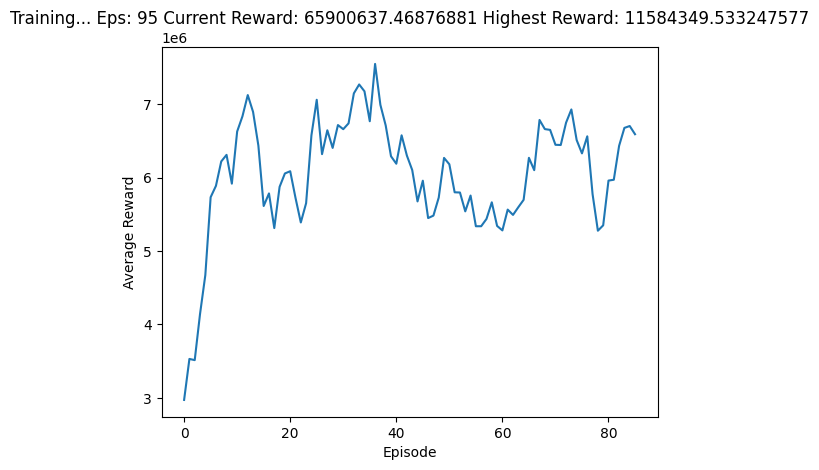

<Figure size 640x480 with 0 Axes>

In [12]:
# Create the trading environment
env = trading_env()

# Create the agent with the specified hyperparameters
agent = Agent(gamma=0.99, epsilon=1.0, batch_size=64, n_actions=3, eps_end=0.03, input_dims=[11], lr=0.003)

# Create empty lists to store profits and epsilon values for each episode
profits, eps_history = [], []

# Set the number of episodes to play
n_games = 1000

# Initialize episode_rewards and episode_durations to empty lists
episode_rewards, episode_durations = [], []

# Play n_games episodes
for i_episode in range(n_games):

    # Initialize the profit and done variables and reset the environment
    profit = 0
    done = False
    observation = env.reset()

    # Play an episode until it is done
    while not done:

        # Choose an action using the agent's policy and take a step in the environment
        action = agent.choose_action(observation)
        observation_, reward, done = env.step(action)

        # Update the profit, store the transition in the agent's memory, and learn from it
        profit += reward
        agent.store_transition(observation, action, reward, observation_, done)
        agent.learn()

        # Update the observation for the next timestep
        observation = observation_

    # Append the final profit and epsilon values for this episode to the lists
    profits.append(profit)
    eps_history.append(agent.epsilon)

    # Compute the average profits over the last 100 episodes
    avg_profits = np.mean(profits[-100:])

    # Print the episode number, profit, average profits, and epsilon value for this episode
    print('episode', i_episode, 'profit %.2f' % profit,
            'avg profit %.2f' % avg_profits,
            'epsilon %.2f' % agent.epsilon)

    # Add the episode's profit to the list of episode rewards
    episode_rewards.append(profit)

    # Add the episode duration to the list of episode durations
    episode_durations.append(env.barpos)

    # Plot the rewards and durations
    cum_reward = sum(episode_rewards[-10:])
    plot_rewards()

# Create a list of episode numbers for plotting
x = [i_episode + 1 for i in range(n_games)]

# Plot the profits over the episodes
plt.plot(x, profits)
